## Data Analysis...

This code block is designed to manage GPU memory usage in TensorFlow. It lists the available physical GPUs, sets a memory limit for each GPU to avoid OOM errors, and optionally enables memory growth. It then lists the logical GPUs and prints the number of physical and logical GPUs. If any errors occur during this process, they are caught and printed.

In [2]:
import tensorflow as tf
import warnings

# Avoid OOM errors by setting GPU Memory Growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])  # Example: Limit to 1GB
            #tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
print(f"\n {gpus}")



2025-02-03 20:05:52.634307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPUs

 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1738593390.904137    7085 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1024 MB memory:  -> device: 0, name: NVIDIA GeForce MX250, pci bus id: 0000:06:00.0, compute capability: 6.1


| No  | Column                    | Non-Null Count         | Dtype   |
| --- | -------------------------- | ---------------------- | ------- |
| 0   | DR_NO                      | 989329 non-null        | int64   |
| 1   | Date Rptd                  | 989329 non-null        | object  |
| 2   | DATE OCC                   | 989329 non-null        | object  |
| 3   | TIME OCC                   | 989329 non-null        | object  |
| 4   | AREA                       | 989329 non-null        | int64   |
| 5   | AREA NAME                  | 989329 non-null        | object  |
| 6   | Rpt Dist No                | 989329 non-null        | int64   |
| 7   | Part 1-2                   | 989329 non-null        | int64   |
| 8   | Crm Cd                     | 989329 non-null        | int64   |
| 9   | Crm Cd Desc                | 989329 non-null        | object  |
| 10  | Mocodes                    | 840950 non-null        | object  |
| 11  | Vict Age                   | 989329 non-null        | int64   |
| 12  | Vict Sex                   | 989329 non-null        | float64 |
| 13  | Vict Descent               | 847756 non-null        | object  |
| 14  | Premis Cd                  | 989313 non-null        | float64 |
| 15  | Premis Desc                | 988761 non-null        | object  |
| 16  | Weapon Used Cd             | 324301 non-null        | float64 |
| 17  | Weapon Desc                | 324301 non-null        | object  |
| 18  | Status                     | 989328 non-null        | object  |
| 19  | Status Desc                | 989329 non-null        | object  |
| 20  | Crm Cd 1                   | 989318 non-null        | float64 |
| 21  | Crm Cd 2                   | 68823 non-null         | float64 |
| 22  | Crm Cd 3                   | 2312 non-null          | float64 |
| 23  | Crm Cd 4                   | 61 non-null            | float64 |
| 24  | LOCATION                   | 989329 non-null        | object  |
| 25  | Cross Street               | 151168 non-null        | object  |
| 26  | LAT                        | 989329 non-null        | float64 |
| 27  | LON                        | 989329 non-null        | float64 |
| 28  | Year                       | 989329 non-null        | int64   |
| 29  | Month                      | 989329 non-null        | int64   |
| 30  | Date/Time                  | 989329 non-null        | object  |
| 31  | Temperature (°C)           | 989329 non-null        | float64 |
| 32  | Dew point (°C)             | 989329 non-null        | float64 |
| 33  | Humidity (%)               | 989329 non-null        | float64 |
| 34  | Precipitation (mm)         | 989329 non-null        | float64 |
| 35  | Wind Direction(degrees°)   | 989329 non-null        | float64 |
| 36  | Windspeed (km/h)           | 989329 non-null        | float64 |
| 37  | Air pressure (hPa)         | 989329 non-null        | float64 |
| 38  | Rainy Day                  | 989329 non-null        | int64   |


## SQL 

### Data Analysis in the Sql DataBase.....

In [31]:
import pandas as pd
import pymysql
from tqdm import tqdm
import warnings

# Ignore specific warning
warnings.filterwarnings("ignore", message="pandas only supports SQLAlchemy connectable")


# Connect to MySQL Database
conn = pymysql.connect(
    host="localhost",
    user="root",
    password="MS@sltc",
    database="LAPD_Crime_Data",
    autocommit=True
)
print("Successfully connected to the database.")


Successfully connected to the database.


In [32]:
# Query to get Crime Count by Hour
query_01 = """
    SELECT 
    CONCAT(
        LPAD(HOUR(Time_OCC), 2, '0'), ':',  -- Extract hour and pad with leading zero
        LPAD(FLOOR(MINUTE(Time_OCC) / 60) * 60, 2, '0')  -- Divide minutes into 30-minute intervals
    ) AS TimeInterval,
    COUNT(*) AS CrimeCount
    FROM crime_data
    GROUP BY TimeInterval
    ORDER BY TimeInterval
    LIMIT 1000000;
"""


In [33]:

# Query to get Crime Descriptions with Locations (limited to 1,000,000 rows)
query_02 = """
    SELECT Crm_Cd_Desc, LAT, LON 
    FROM crime_data 
    LIMIT 1000000;
"""


In [34]:
query_03 = """
WITH HourlyCrime AS (
    SELECT 
        CONCAT(
            LPAD(HOUR(Time_OCC), 2, '0'), ':', '00'
        ) AS Hour,
        Crm_Cd_Desc AS CrimeType,
        COUNT(*) AS CrimeCount
    FROM crime_data
    GROUP BY CONCAT(LPAD(HOUR(Time_OCC), 2, '0'), ':', '00'), CrimeType
), CrimeTotals AS (
    SELECT 
        CONCAT(
            LPAD(HOUR(Time_OCC), 2, '0'), ':', '00'
        ) AS Hour,
        COUNT(*) AS TotalCrimes
    FROM crime_data
    GROUP BY CONCAT(LPAD(HOUR(Time_OCC), 2, '0'), ':', '00')
), RankedCrimes AS (
    SELECT 
        h.Hour,
        c.TotalCrimes,
        h.CrimeType,
        h.CrimeCount,
        RANK() OVER (PARTITION BY h.Hour ORDER BY h.CrimeCount DESC) AS ranks
    FROM HourlyCrime h
    JOIN CrimeTotals c ON h.Hour = c.Hour
)
SELECT 
    Hour,
    TotalCrimes AS `Total Crime Happened`,
    CrimeType AS `Mostly Happened Crimes`,
    CrimeCount AS `Amount`
FROM RankedCrimes
WHERE ranks <= 5
ORDER BY Hour, ranks
LIMIT 1000000;
"""

In [35]:
# Query to get total number of rows for the progress bar
count_query = "SELECT COUNT(*) FROM crime_data;"
total_rows = pd.read_sql(count_query, conn).iloc[0, 0]
total_rows

989329

In [36]:
# Read large data in chunks with tqdm progress bar
chunk_size = 1  # Adjust chunk size if needed

num_chunks = 1440/60
# Read data in chunks with an accurate progress bar
print(f"Total rows to fetch: {total_rows}",f"\nTotal Chuncks:{num_chunks}")


Total rows to fetch: 989329 
Total Chuncks:24.0


In [37]:
chunks_03= []
print("Fetching crime descriptions and locations...")
for chunk in tqdm(pd.read_sql_query(query_03, conn, chunksize=chunk_size),total=24,desc="Reading data chunks for query 03 : "):
    chunks_03.append(chunk)

# Concatenate all chunks into a single DataFrame
Results_03_raw = pd.concat(chunks_03, ignore_index=True)
print("Data fetching completed.")

Fetching crime descriptions and locations...


Reading data chunks for query 03 : : 120it [00:00, 920.06it/s]           

Data fetching completed.


In [38]:
Results_03_raw

,Hour,Total Crime Happened,Mostly Happened Crimes,Amount
0,00:00,40200,THEFT OF IDENTITY,6111
1,00:00,40200,VEHICLE - STOLEN,3723
2,00:00,40200,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",2580
3,00:00,40200,INTIMATE PARTNER - SIMPLE ASSAULT,2419
4,00:00,40200,BURGLARY FROM VEHICLE,2354
...,...,...,...,...
115,23:00,41528,VEHICLE - STOLEN,6295
116,23:00,41528,BURGLARY FROM VEHICLE,3622
117,23:00,41528,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",3030
118,23:00,41528,INTIMATE PARTNER - SIMPLE ASSAULT,2989


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt


<Figure size 2500x1500 with 0 Axes>

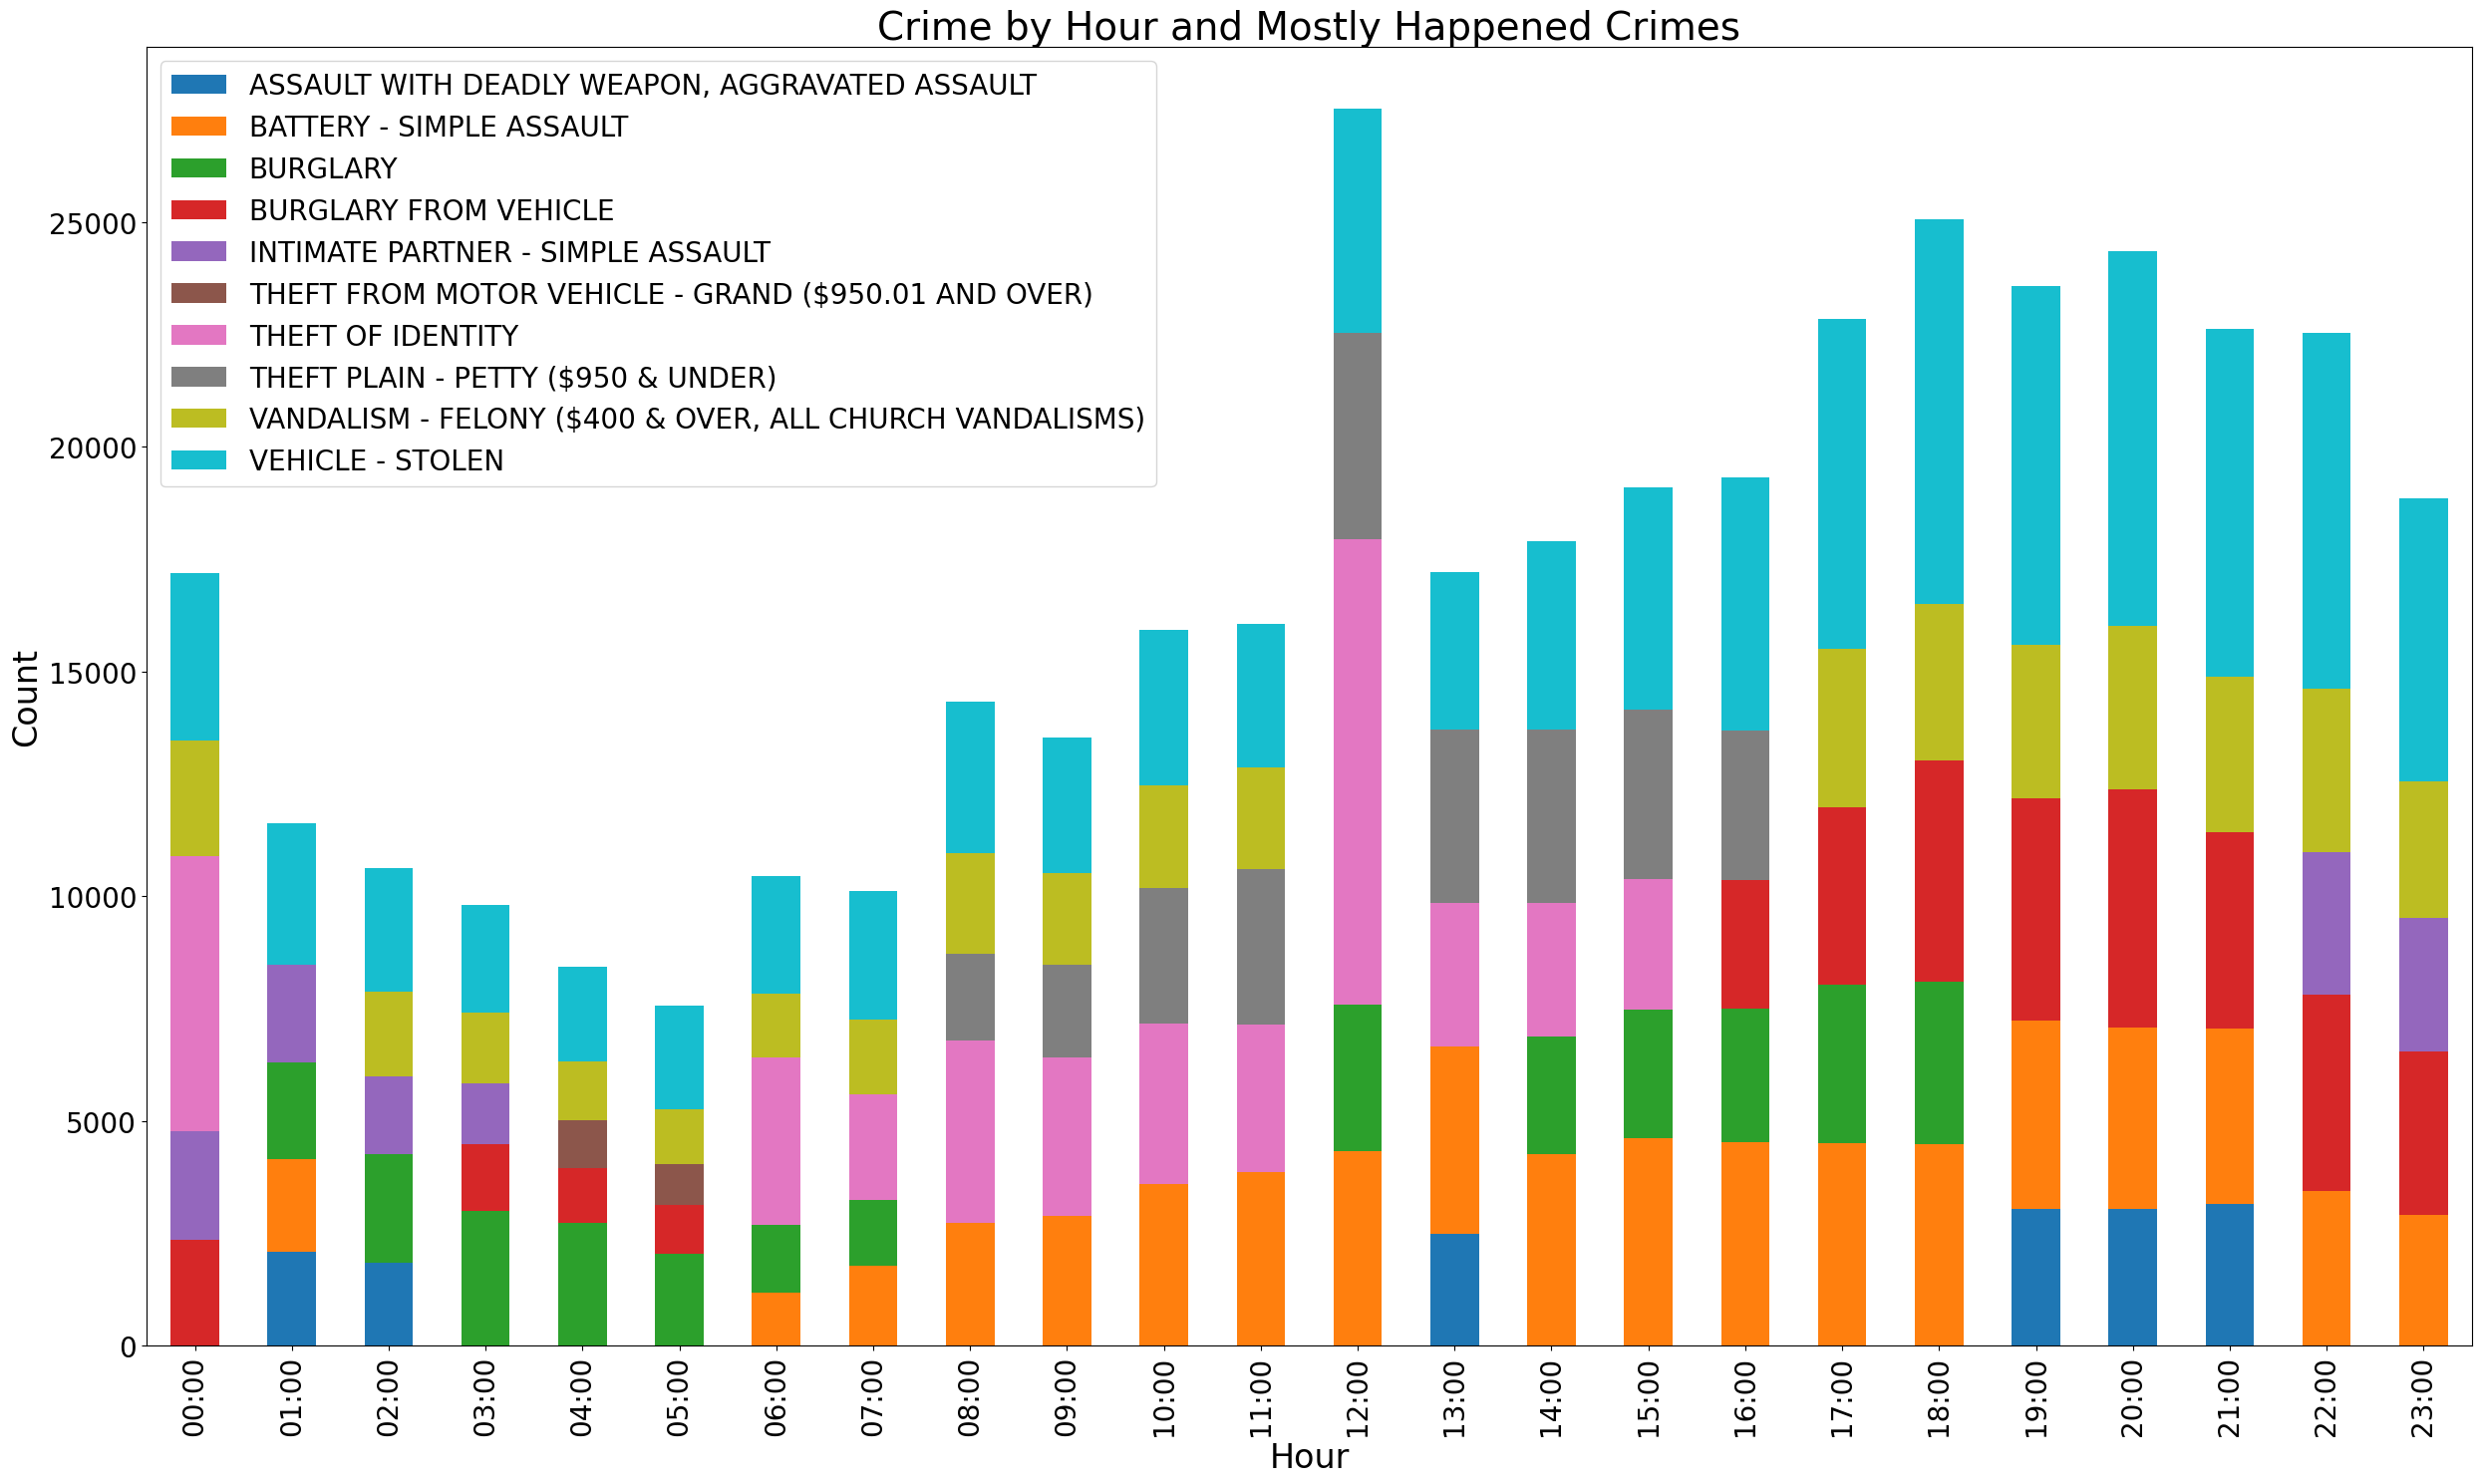

In [57]:
# Plotting the crime by hour and mostly happened crimes
plt.figure(figsize=(25, 15))
# Group by 'Hour' and 'Mostly Happened Crimes' and sum the 'Amount'
hourly_crime = Results_03_raw.groupby(['Hour', 'Mostly Happened Crimes']).sum().reset_index()

# Pivot the data to have hours as rows and crime types as columns
hourly_crime_pivot = hourly_crime.pivot(index='Hour', columns='Mostly Happened Crimes', values='Amount')

# Use a light color palette
#colors = sns.color_palette('Pastel1')

# Plot the data with the light color palette
hourly_crime_pivot.plot(kind='bar', stacked=True, figsize=(25, 15),)# color=colors)

# Adding labels and title
plt.title('Crime by Hour and Mostly Happened Crimes', fontsize=28)
plt.xlabel('Hour', fontsize=24)
plt.ylabel('Count', fontsize=24)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

# Show the plot
plt.tight_layout()
plt.show()

In [7]:
chunks_01 = []
print("Fetching crime descriptions and locations...")
for chunk in tqdm(pd.read_sql_query(query_01, conn, chunksize=chunk_size),total=24,desc="Reading data chunks for query 01 : "):
    chunks_01.append(chunk)

# Concatenate all chunks into a single DataFrame
Results_01_raw = pd.concat(chunks_01, ignore_index=True)
print("Data fetching completed.")

Fetching crime descriptions and locations...


Reading data chunks for query 01 : 100%|██████████| 24/24 [00:00<00:00, 1607.50it/s]

Data fetching completed.


In [10]:
# Read large data in chunks with tqdm progress bar
chunk_size = 1000  # Adjust chunk size if needed
chunks = []

num_chunks = total_rows // chunk_size + (1 if total_rows % chunk_size != 0 else 0)
# Read data in chunks with an accurate progress bar
print(f"Total rows to fetch: {total_rows}")

print("Fetching crime descriptions and locations...")
for chunk in tqdm(pd.read_sql_query(query_02, conn, chunksize=chunk_size),total=num_chunks,desc="Reading data chunks"):
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
Results_02_raw = pd.concat(chunks, ignore_index=True)
print("Data fetching completed.")


Total rows to fetch: 989329
Fetching crime descriptions and locations...


Reading data chunks: 100%|██████████| 990/990 [00:01<00:00, 763.88it/s]


Data fetching completed.


In [11]:
# Processing Results_02 with tqdm progress bar to group locations by crime description
print("Processing data to group locations by crime description...")

# Group by 'Crm_Cd_Desc' and count the number of occurrences
crime_counts = Results_02_raw.groupby('Crm_Cd_Desc').size().reset_index(name='Incident_Count')


grouped_data = {}

for idx, row in tqdm(Results_02_raw.iterrows(), total=Results_02_raw.shape[0], desc="Processing crime locations"):
    crm_desc = row['Crm_Cd_Desc']
    lat, lon = row['LAT'], row['LON']
    
    if crm_desc not in grouped_data:
        grouped_data[crm_desc] = []
    
    grouped_data[crm_desc].append(((lat),(lon)))

# Convert grouped data to DataFrame
Results_02 = pd.DataFrame({
    'Crm_Cd_Desc': list(grouped_data.keys()),
    'Location_CRM': list(grouped_data.values())
})

# Step 4: Merge the counts into the Results_02 DataFrame
Results_02 = Results_02.merge(crime_counts, on='Crm_Cd_Desc')

# Reorder columns to place 'Incident_Count' first
Results_02 = Results_02[['Crm_Cd_Desc','Incident_Count',  'Location_CRM']]


Processing data to group locations by crime description...


Processing crime locations: 100%|██████████| 989329/989329 [01:32<00:00, 10663.39it/s]


### Close the database connection

In [12]:
conn.close()
print("Database connection closed.")


Database connection closed.


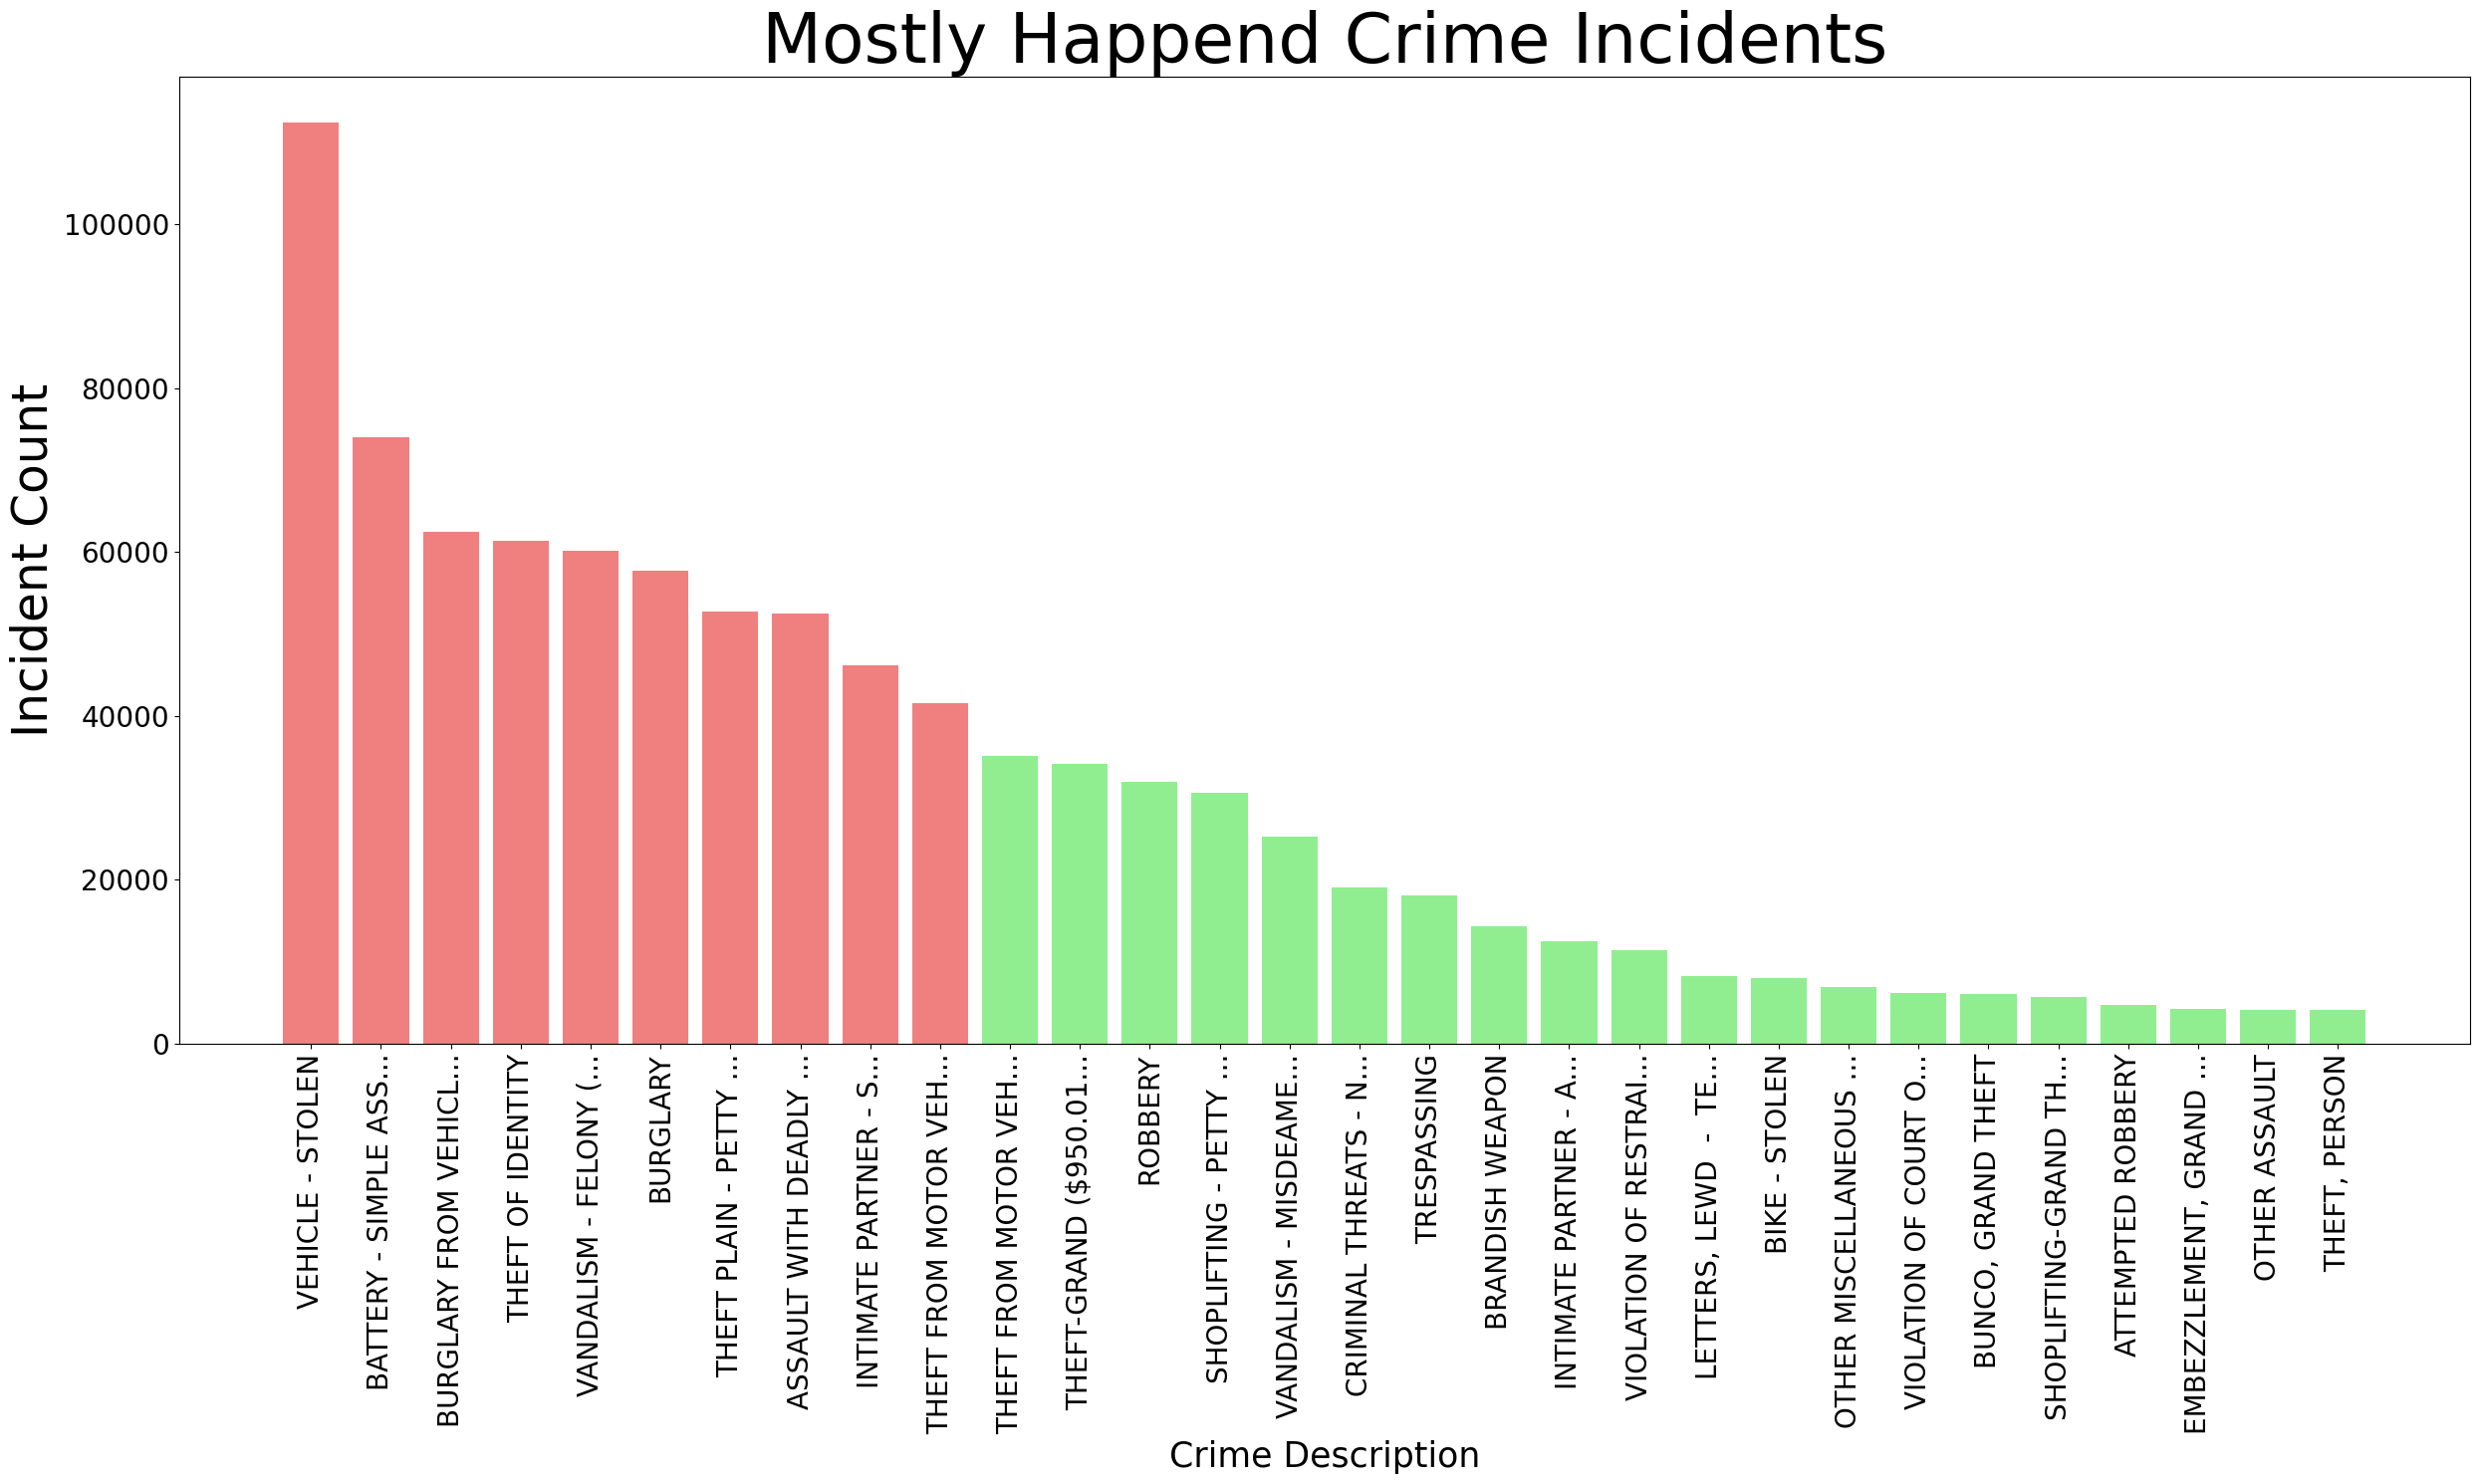

In [13]:
import matplotlib.pyplot as plt

# Plotting the incident count for each crime description
plt.figure(figsize=(25, 15))  # Adjust figure size as needed
#plt.bar(Results_02['Crm_Cd_Desc'], Results_02['Incident_Count'], color='blue')
# Filter to show only the top 30 most frequent crimes
top_30_crimes = Results_02.nlargest(30, 'Incident_Count')

# Highlight the top 10 most frequent crimes in light-red
top_10_crimes = top_30_crimes.nlargest(10, 'Incident_Count')
colors = ['lightcoral' if crime in top_10_crimes['Crm_Cd_Desc'].values else 'lightgreen' for crime in top_30_crimes['Crm_Cd_Desc'].values]

plt.bar(top_30_crimes['Crm_Cd_Desc'], top_30_crimes['Incident_Count'], color=colors)

# Truncate x-tick labels to 20 characters
truncated_labels = [label[:20] + '...' if len(label) > 20 else label for label in top_30_crimes['Crm_Cd_Desc']]
plt.xticks(ticks=range(len(truncated_labels)), labels=truncated_labels, fontsize=20)
#  Adding labels and title
# plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.title('Mostly Happend Crime Incidents', fontsize=50)
plt.xlabel('Crime Description', fontsize=25)
plt.ylabel('Incident Count', fontsize=35)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()


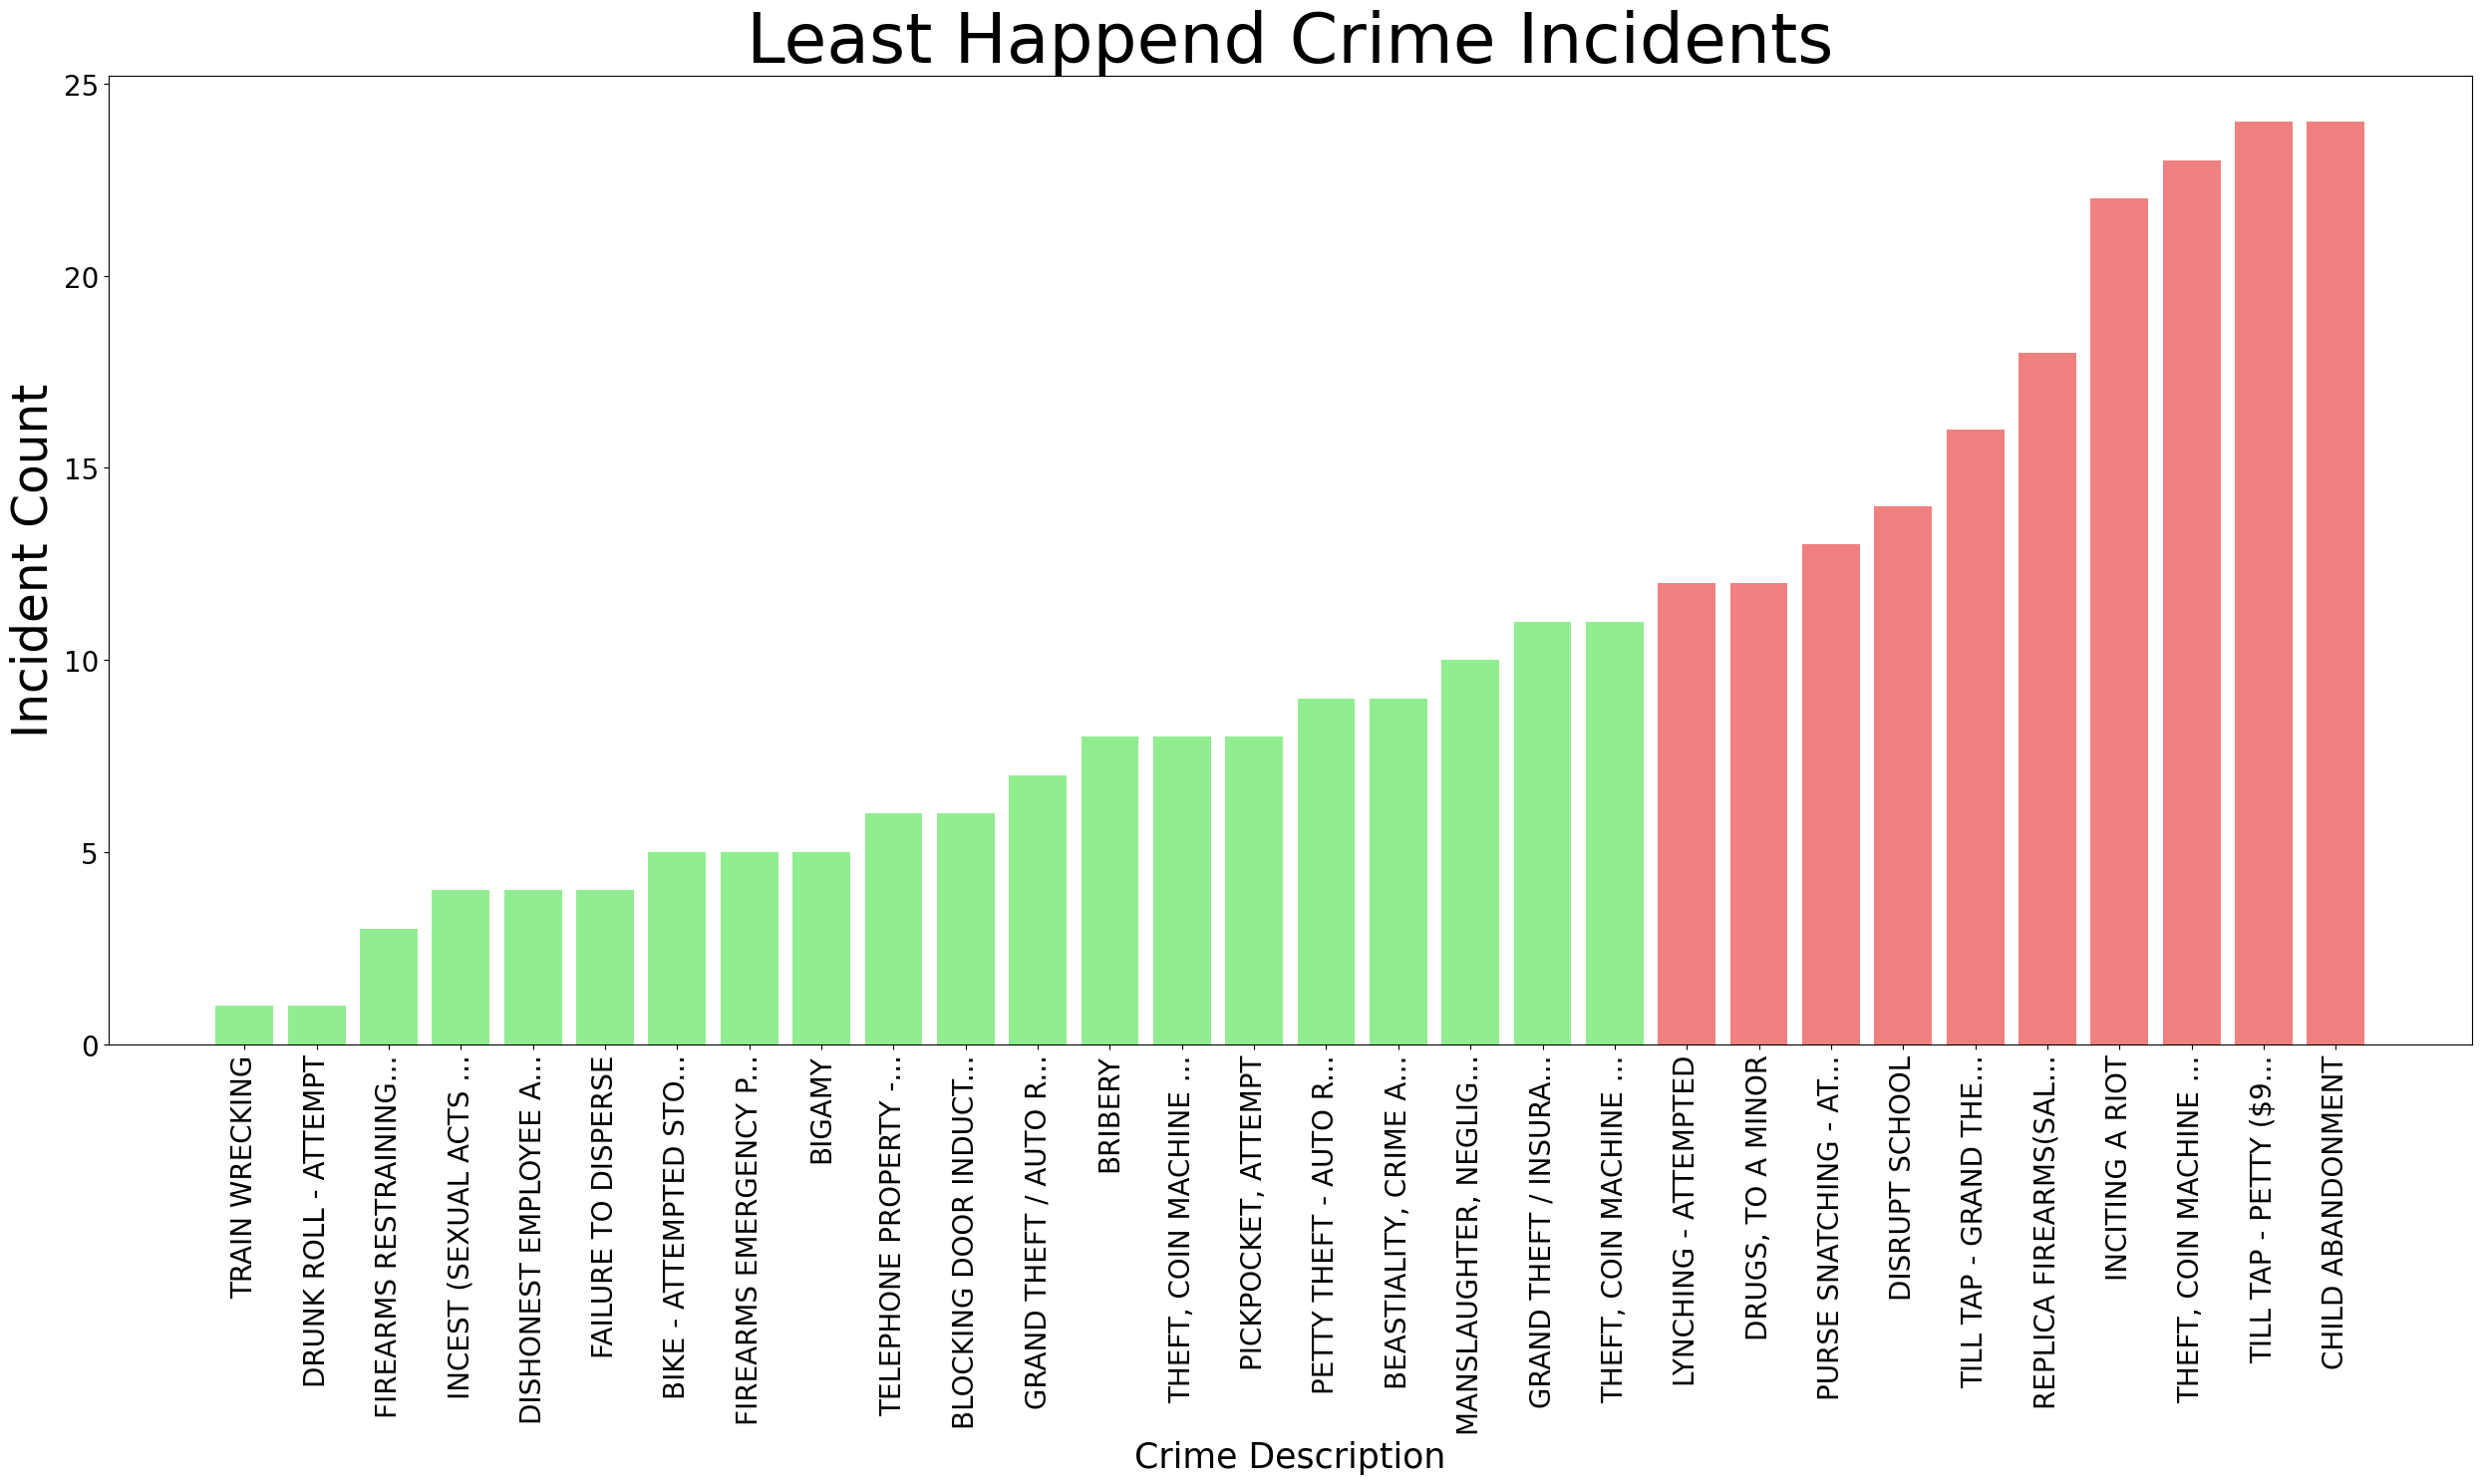

In [14]:
# Plotting the incident count for each crime description
plt.figure(figsize=(25, 15))  # Adjust figure size as needed
#plt.bar(Results_02['Crm_Cd_Desc'], Results_02['Incident_Count'], color='blue')
# Filter to show only the top 30 most frequent crimes
top_30_crimes_low = Results_02.nsmallest(30, 'Incident_Count')

# # Highlight the top 10 most frequent crimes in light-red
top_10_crimes_low = top_30_crimes_low.nlargest(10, 'Incident_Count')
colors = ['lightcoral' if crime in top_10_crimes_low['Crm_Cd_Desc'].values else 'lightgreen' for crime in top_30_crimes_low['Crm_Cd_Desc'].values]

plt.bar(top_30_crimes_low['Crm_Cd_Desc'], top_30_crimes_low['Incident_Count'], color=colors)

# Truncate x-tick labels to 20 characters
truncated_labels = [label[:20] + '...' if len(label) > 20 else label for label in top_30_crimes_low['Crm_Cd_Desc']]
plt.xticks(ticks=range(len(truncated_labels)), labels=truncated_labels, fontsize=20)
# Adding labels and title
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.title('Least Happend Crime Incidents', fontsize=50)
plt.xlabel('Crime Description', fontsize=25)
plt.ylabel('Incident Count', fontsize=35)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=90)

# # Show the plot
plt.tight_layout()
plt.show()

In [15]:
Results_01=Results_01_raw 

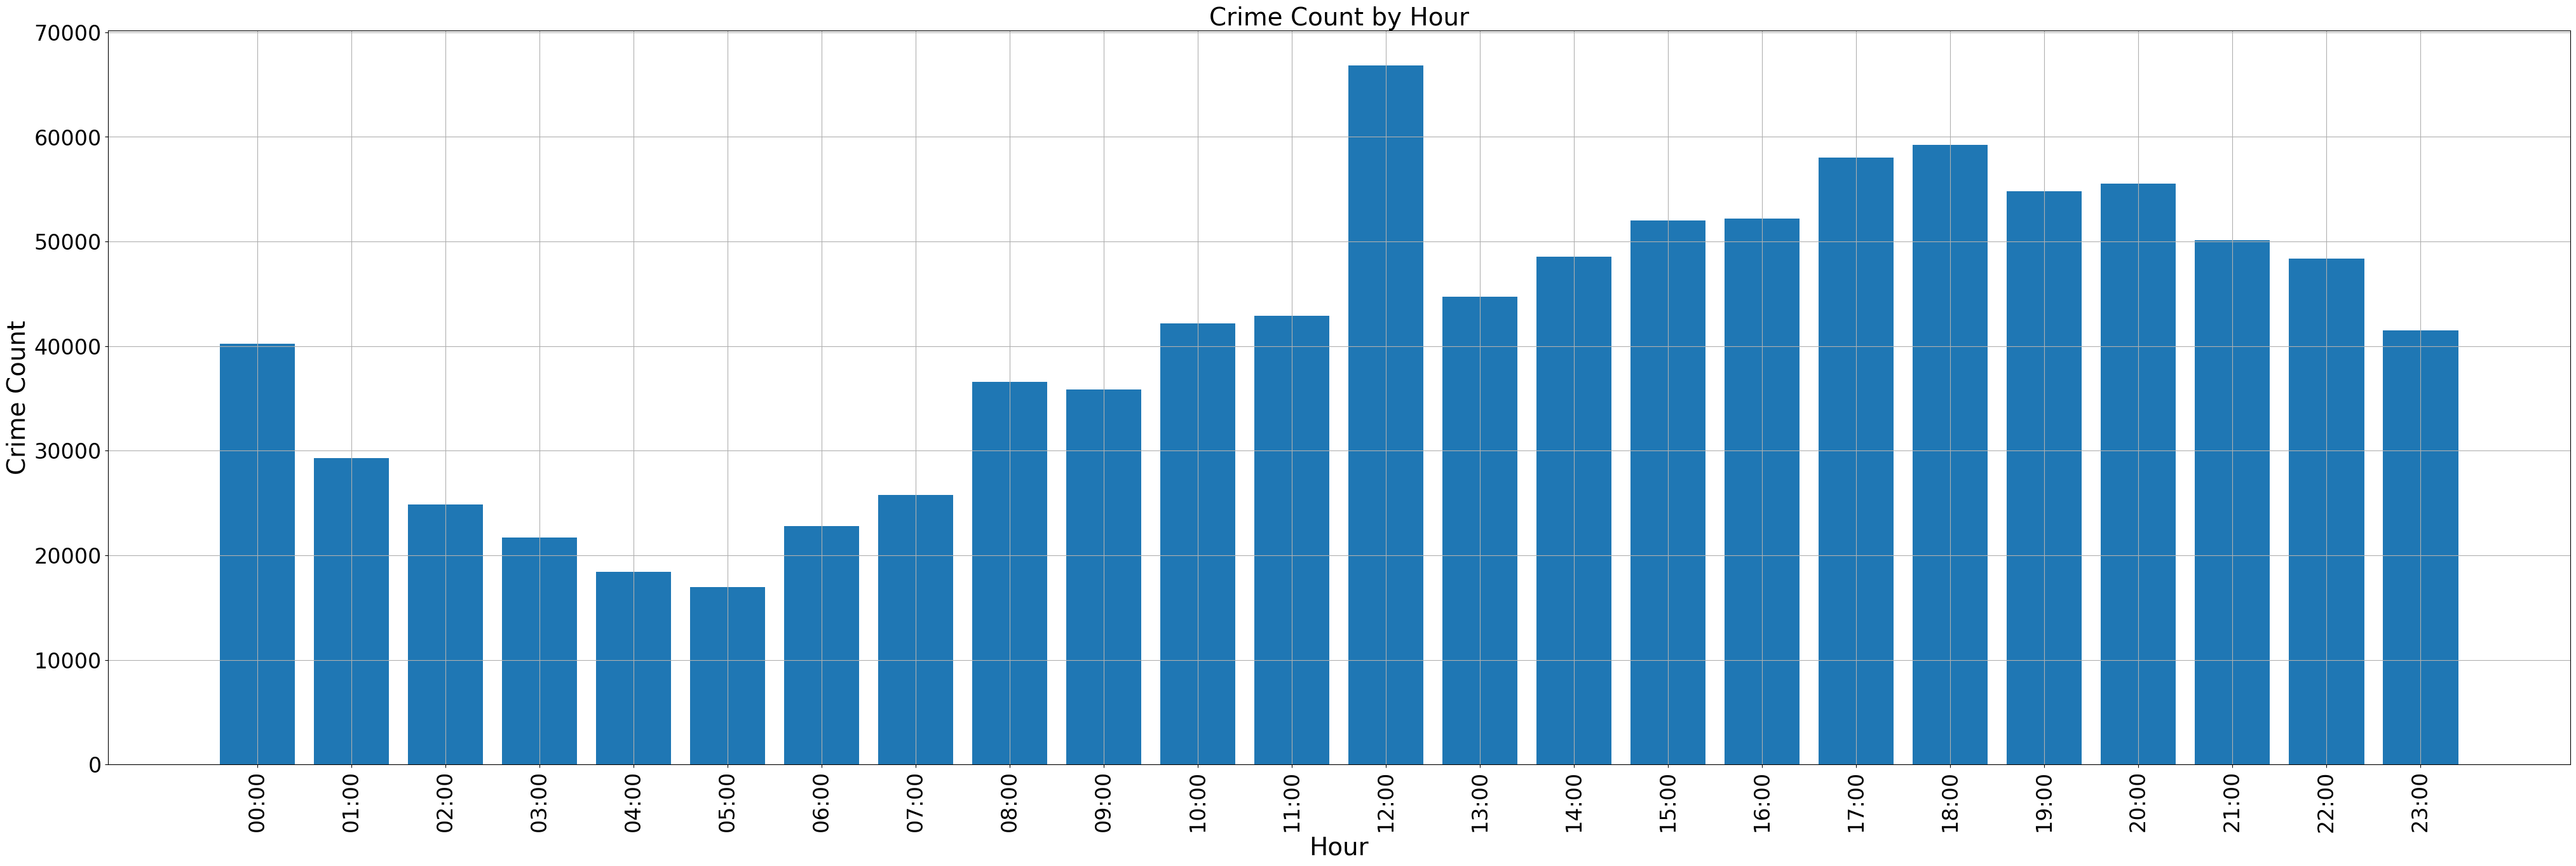

In [18]:
# Plotting

plt.figure(figsize=(50, 15))
#plt.plot(Results_01['TimeInterval'], Results_01['CrimeCount'][0:120], marker='o', linestyle='-')
plt.bar(Results_01['TimeInterval'], Results_01['CrimeCount'][0:120])
plt.title('Crime Count by Hour',fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Hour', fontsize=28)
plt.ylabel('Crime Count', fontsize=28)
plt.xticks(rotation=90)  # Rotate for better readability
plt.grid(True)
plt.show()

In [17]:
Results_02

,Crm_Cd_Desc,Incident_Count,Location_CRM
0,VEHICLE - STOLEN,112350,"[(34.0375, -118.351), (34.082, -118.213), (34...."
1,BURGLARY FROM VEHICLE,62427,"[(34.0444, -118.263), (34.1774, -118.539), (34..."
2,BIKE - STOLEN,8063,"[(34.021, -118.3), (34.0303, -118.287), (34.04..."
3,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),5669,"[(34.1576, -118.439), (33.9874, -118.283), (34..."
4,ARSON,2460,"[(34.0536, -118.279), (33.9679, -118.274), (33..."
...,...,...,...
135,INCITING A RIOT,22,"[(34.1016, -118.327), (33.9493, -118.396), (33..."
136,DISHONEST EMPLOYEE ATTEMPTED THEFT,4,"[(34.1608, -118.51), (34.1794, -118.396), (34...."
137,FAILURE TO DISPERSE,4,"[(34.0566, -118.257), (34.0477, -118.25), (34...."
138,TRAIN WRECKING,1,"[(33.7798, -118.241)]"
